<a href="https://colab.research.google.com/github/aleksandraburakowska1/Maly_projekt3_Ola_i_Michal/blob/main/projekt_1_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



### 1. Wczytanie i czyszczenie danych

In [63]:
import pandas as pd
import requests
import zipfile
import io, os

from io_clean import (
    download_gios_archive,
    usun_wiersze_opisowe,
    load_gios_metadata,
    use_station_header,
    build_old2new,
    mapuj_kolumny_z_podgladem,
    build_kod2miasto,
    dodaj_multiindex
)



In [64]:
from metrics import (
    ensure_datetime,
    shift_midnight_to_prev_day,
    add_city_and_month,
    daily_station_mean,
    exceedance_days_per_year,
    select_top_bottom_stations
)

In [ ]:
from viz import (
    plot_monthly_pm25,
    plot_pm25_heatmaps
)

In [66]:
# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
#zmieniam lata
gios_url_ids = {2015: '236', 2018: '603', 2021: '486', 2024: '582'}
gios_pm25_file = {2015: '2015_PM25_1g.xlsx', 2018: '2018_PM25_1g.xlsx', 2021: '2021_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}
meta_path = "Metadane oraz kody stacji i stanowisk pomiarowych.xlsx"
dfmeta = load_gios_metadata(meta_path)

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

In [67]:
#zmiana zalecana przez prowadzącego
lata = [2015, 2018, 2021, 2024]

datasets = {}
for rok in lata:
    datasets[rok] = download_gios_archive(rok, gios_url_ids[rok], gios_pm25_file[rok])

datasets[2024].head(10)


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,Nr,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
1,Kod stacji,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
2,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
3,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
4,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
5,Kod stanowiska,DsChojnowMalMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsKlodzSzkol-PM2.5-1g,DsKudowaSzkoMOB-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpNaklWawrzy-PM2.5-1g,...,WmElkStadion-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpKoscianMayMOB-PM2.5-1g,WpPoznDabrow-PM2.5-1g,WpPoznSzwajc-PM2.5-1g,ZpDabkiSztorMOB-PM2.5-1g,ZpKolZolkiew-PM2.5-1g,ZpSzczAndrze-PM2.5-1g,ZpSzczPilsud-PM2.5-1g
6,2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
7,2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
8,2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7
9,2024-01-01 04:00:00,NaN,11.2,27.6,NaN,14.7,18.5,66.8,36.2,42.6,...,10,18.7,44.1,26.9,16.3,75.8,26.4,32.6,17,20.1


In [68]:

# tutaj w tym fragmencie usuwam niepotrzebne wiersze (np. "wskaźnik")
# słownik z danymi źródłowymi (twoje DataFrame’y)

# zmienione według uwag prowadzącego

cleaned = usun_wiersze_opisowe(datasets)

cleaned[2018].head()
# odnosząc do poprzedniego: zamiast df2024_clean → używamy cleaned[2024]


2015: usunięto 2 wierszy opisowych, pozostało 8761
2018: usunięto 5 wierszy opisowych, pozostało 8761
2021: usunięto 5 wierszy opisowych, pozostało 8761
2024: usunięto 5 wierszy opisowych, pozostało 8785


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,Kod stacji,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,KpWloclOkrze,LbLubObywate,LdLodzCzerni,...,SkKonsGranatMOB,SkPolaRuszcz,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznDabrow,ZpSzczAndr01,ZpSzczPils02
1,2018-01-01 01:00:00,"43,0102","71,494","70,2","49,2716","69,6873","18,778",NaN,"30,9","16,0",...,NaN,"27,68",NaN,"76,8469","25,9266","41,3687",NaN,NaN,"26,5445","12,8035"
2,2018-01-01 02:00:00,"5,38425","7,89305","13,1522","36,236","42,3178",NaN,NaN,"54,8","83,0",...,NaN,"18,48",NaN,"39,3395","32,7522","25,8502",NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,"4,52882","12,5392","12,5","14,7514",NaN,NaN,NaN,"24,3","16,0",...,NaN,"15,59",NaN,"23,2554","37,6664","22,4599",NaN,NaN,"10,4332","32,0944"
4,2018-01-01 04:00:00,"8,68036","5,03196","8,85164","17,1654",NaN,"13,353",NaN,"15,1","14,0",...,NaN,"12,32",NaN,"22,3614","32,4625","20,1625",NaN,NaN,"28,1885","27,3274"


In [69]:
# zamieniam przecinki na kropki (widać że np. 2018 są przecinki zamiast kropek)

for year in cleaned:
    cleaned[year] = cleaned[year].replace(',', '.', regex=True)



In [70]:
cleaned[2018].head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,Kod stacji,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,KpWloclOkrze,LbLubObywate,LdLodzCzerni,...,SkKonsGranatMOB,SkPolaRuszcz,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznDabrow,ZpSzczAndr01,ZpSzczPils02
1,2018-01-01 01:00:00,43.0102,71.494,70.2,49.2716,69.6873,18.778,NaN,30.9,16.0,...,NaN,27.68,NaN,76.8469,25.9266,41.3687,NaN,NaN,26.5445,12.8035
2,2018-01-01 02:00:00,5.38425,7.89305,13.1522,36.236,42.3178,NaN,NaN,54.8,83.0,...,NaN,18.48,NaN,39.3395,32.7522,25.8502,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,4.52882,12.5392,12.5,14.7514,NaN,NaN,NaN,24.3,16.0,...,NaN,15.59,NaN,23.2554,37.6664,22.4599,NaN,NaN,10.4332,32.0944
4,2018-01-01 04:00:00,8.68036,5.03196,8.85164,17.1654,NaN,13.353,NaN,15.1,14.0,...,NaN,12.32,NaN,22.3614,32.4625,20.1625,NaN,NaN,28.1885,27.3274


In [71]:
#mapowanie stary kod: nowy kod w słowniku
old2new = build_old2new(dfmeta)
old2new

{'DsBogatMob': 'DsBogatFrancMOB',
 'DsCzer02': 'DsCzerStraza',
 'DsDzia01': 'DsDzialoszyn',
 'DsDzierPilsA': 'DsDziePilsud',
 'DsGlogWita': 'DsGlogWiStwo',
 'DsJeleniaGoraA': 'DsJelGorOgin',
 'DsJeleniaGoraPM': 'DsJelGorSoko',
 'DsKlodzkoA': 'DsKlodzSzkol',
 'DsZabkowSemi': 'DsZabkPowWar',
 'DsPolanZdrojMOB': 'DsKudSlon',
 'DsLegRzeczA': 'DsLegPolarna',
 'DsNRudaSrebP': 'DsNowRudSreb',
 'DsOlawaSemi': 'DsOlawZolnAK',
 'DsOlesnicaPM': 'DsOlesBrzozo',
 'DsOsieczow': 'DsOsieczow21',
 'DsPolkKasz': 'DsPolKasztan',
 'DsSniezka': 'DsSniezkaObs',
 'DsSwidMob': 'DsSwidnMarciMOB',
 'DsSwidRynek': 'DsSwidnRynek',
 'DsSzczDZPM': 'DsSzczaKolej',
 'DsTrzebnica': 'DsTrzebniMaj',
 'DsWalbWysA': 'DsWalbrzWyso',
 'DsWrocWisA': 'DsWrocAlWisn',
 'DsWrocBartA': 'DsWrocBartni',
 'DsWrocGrobla': 'DsWrocNaGrob',
 'DsWrocKorzA': 'DsWrocWybCon',
 'DsZgorzBohA': 'DsZgorBohGet',
 'DsZlotoryjaPM': 'DsZlotoStasz',
 'KpBrodnicaKochanowskiego': 'KpBrodKochan',
 'KpBydgBerlinga': 'KpBydFieldor',
 'KpBydBerling': 'KpB

In [72]:
#Zamiana wiersza "Kod stacji" na nagłówek i dodanie kolumny 'Data', żeby ujednolicić format
#potem zmapuję stare kody stacji na nowe zgodnie z metadanymi (słownik powyżej)

hdr = {}
for rok in lata:
    hdr[rok] = use_station_header(cleaned[rok])
hdr[2015]

,Data,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,LbLubObywate,LdLodzCzerni,LdLodzGdansk,...,SkMalo11List,SkPolaRuszcz,SlGliwicMewy,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznPolank,ZpSzczAndr01,ZpSzczPils02
0,2015-01-01 01:00:00,151.112,78,50,29.2,95.5,27.352,71.1012,59.73,NaN,...,39.6,72.4,77.828,51.389,49.9464,44.060833,25.5,24.4768,NaN,NaN
1,2015-01-01 02:00:00,262.566,42,33.8244,27.1,86.1,78.0064,95.2582,185.92,NaN,...,33.6,57.2,50.0552,37.709,45.6291,49.943329,32.5,29.86,81.8501,215.379
2,2015-01-01 03:00:00.005000,222.83,27,28.7215,7.9,23.8,21.1056,49.5078,54.25,NaN,...,35,41.9,52.0277,41.984,49.2093,20.688448,24.3,29.3744,25.7333,27.7458
3,2015-01-01 04:00:00.010000,210.767,24,20.6891,7.1,15.9,16.9088,60.8468,50.15,NaN,...,34.8,36.7,49.1084,45.404,53.316,17.437717,24.4,28.34,18.624,26.5201
4,2015-01-01 05:00:00.015000,191.211,22,22.5335,9.2,15,16.8112,49.3106,39.17,NaN,...,35.8,36,44.0588,36.854,51.5259,15.532262,25,25.2286,17.6545,31.0393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015-12-31 20:00:43.770000,13.7734,29.2072,24.4965,NaN,76.2,NaN,62.7976,31,57,...,28,59,205.944,158.52,42.9334,34.510277,75.05,36.3858,30.6219,30.2969
8756,2015-12-31 21:00:43.775000,20.8195,36.8677,39.4025,55.4,66.9,NaN,105.59,46,60,...,36.8,57.4,218.516,143.729,45,35.861,62.8491,40.31,50.1254,27.2376
8757,2015-12-31 22:00:43.780000,11.7978,61.041,52.4493,NaN,69.2,NaN,232.0938,46,58,...,33.3,73.8,169.238,131.673,63.9197,36.309914,70.6655,43.079,38.0602,28.3642
8758,2015-12-31 23:00:43.785000,16.6281,67.5414,59.3307,71.1,65.5,NaN,203.4012,49,57,...,38.2,70.9,115.688,119.533,56.2223,38.686676,80.2882,52.32,193.129,34.8272


In [73]:

kod2miasto = build_kod2miasto(dfmeta)
kod2miasto


{'DsBialka': 'Białka',
 'DsBielGrot': 'Bielawa',
 'DsBogatFrancMOB': 'Bogatynia',
 'DsBogChop': 'Bogatynia',
 'DsBogZatonieMob': 'Bogatynia',
 'DsBoleslaMOB': 'Bolesławiec',
 'DsBrzegGlog': 'Brzeg Głogowski',
 'DsChojnowKil': 'Chojnów',
 'DsChojnowMalMOB': 'Chojnów',
 'DsCzar07': 'Czarna Góra',
 'DsCzerStraza': 'Czerniawa',
 'DsCzLasMob': 'Czarny Las',
 'DsDusznikMOB': 'Duszniki-Zdrój',
 'DsDuszZiel': 'Duszniki-Zdrój',
 'DsDzialoszyn': 'Działoszyn',
 'DsDziePilsud': 'Dzierżoniów',
 'DsDzierKras': 'Dzierżoniów',
 'DsGlogMob': 'Głogów',
 'DsGlogNorw': 'Głogów',
 'DsGlogNorwArch': 'Głogów',
 'DsGlogOrzech': 'Głogów',
 'DsGlogowko': 'Głogówko',
 'DsGlogSikor': 'Głogów',
 'DsGlogWiStwo': 'Głogów',
 'DsGrodziec': 'Grodziec Mały',
 'DsJasnaSport': 'Jasna Góra',
 'DsJawDmow': 'Jawor',
 'DsJaworMOB': 'Jawor',
 'DsJedlinaZdrMOB': 'Jedlina-Zdrój',
 'DsJedlZdroj': 'Jedlina-Zdrój',
 'DsJelGorOgin': 'Jelenia Góra',
 'DsJelGorSoko': 'Jelenia Góra',
 'DsJelw05': 'Jeleniów',
 'DsJgCiep': 'Jelenia Góra'

In [74]:
mapped = {}
for rok in lata:
    mapped[rok] = mapuj_kolumny_z_podgladem(hdr[rok], old2new)

 Zmienione kolumny:
   PdBialWaszyn  →  PdBialUpalna
   PmGdaLeczk08  →  PmGdaLeczkow
   PmKosTargo12  →  PmKosTargowa
   ZpSzczAndr01  →  ZpSzczAndrze
   ZpSzczPils02  →  ZpSzczPilsud
 Zmienione kolumny:
   MzKonJezMos  →  MzKonJezWieMOB
   PdBialWaszyn  →  PdBialUpalna
   PdSuwPulaskp  →  PdSuwPulask2
   PmGdaLeczk08  →  PmGdaLeczkow
   PmKosTargo12  →  PmKosTargowa
   ZpSzczAndr01  →  ZpSzczAndrze
   ZpSzczPils02  →  ZpSzczPilsud
 Zmienione kolumny:
   PdBialWaszyn  →  PdBialUpalna
 Żadna kolumna nie wymagała zmiany.


In [75]:
mapped_proc = {}

for rok in lata:
    df_dt = ensure_datetime(mapped[rok])
    df_shift = shift_midnight_to_prev_day(df_dt)
    mapped_proc[rok] = df_shift


Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)
Kolumna Data przekonwertowana na datetime (błędne wartości: 0)


In [76]:
df_all = pd.concat(
    [mapped_proc[rok] for rok in lata],
    join="inner",
    ignore_index=True
)


In [77]:
df_all[df_all['Data'].dt.year == 2018].head()

,Data,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,LbLubObywate,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,...,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,PmKosTargowa,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
8760,2018-01-01 01:00:00,43.0102,71.494,70.2,49.2716,69.6873,30.9,16.0,91.757,NaN,...,16.0,12.268,92.1811,NaN,76.8469,25.9266,41.3687,NaN,26.5445,12.8035
8761,2018-01-01 02:00:00,5.38425,7.89305,13.1522,36.236,42.3178,54.8,83.0,54.707,8.42542,...,11.0,7.84633,23.5344,5.74148,39.3395,32.7522,25.8502,NaN,NaN,NaN
8762,2018-01-01 03:00:00,4.52882,12.5392,12.5,14.7514,NaN,24.3,16.0,17.657,14.936,...,25.0,7.01749,14.8063,8.72956,23.2554,37.6664,22.4599,NaN,10.4332,32.0944
8763,2018-01-01 04:00:00,8.68036,5.03196,8.85164,17.1654,NaN,15.1,14.0,4.832,11.0771,...,20.0,8.08144,13.6979,10.7329,22.3614,32.4625,20.1625,NaN,28.1885,27.3274
8764,2018-01-01 05:00:00,7.2,11.9136,7.29656,12.5788,NaN,12.6,12.0,7.682,11.3799,...,25.0,7.90984,11.952,10.9749,28.9092,27.135,18.3681,NaN,40.1738,61.1957


In [78]:
#MultiIndex to po prostu wielopoziomowy indeks — czyli taki, gdzie:
#każda kolumna (lub wiersz) ma kilka warstw etykiet zamiast jednej.
df_all_multi = dodaj_multiindex(df_all, kod2miasto)
df_all_multi.head(10)


Miejscowość                         Jelenia Góra      Wrocław               \
Kod stacji                     Data DsJelGorOgin DsWrocAlWisn DsWrocWybCon   
0           2015-01-01 01:00:00.000      151.112           78           50   
1           2015-01-01 02:00:00.000      262.566           42      33.8244   
2           2015-01-01 03:00:00.005       222.83           27      28.7215   
3           2015-01-01 04:00:00.010      210.767           24      20.6891   
4           2015-01-01 05:00:00.015      191.211           22      22.5335   
5           2015-01-01 06:00:00.020      114.636           19      18.5107   
6           2015-01-01 07:00:00.025      21.4669           23      27.4382   
7           2015-01-01 08:00:00.030      19.7269           32      23.8024   
8           2015-01-01 09:00:00.035      26.6903           38      32.6736   
9           2015-01-01 10:00:00.040      25.9544           38       38.217   

Miejscowość    Bydgoszcz                    Lublin         Łódź       Zgierz  \
Kod stacji  KpBydPlPozna KpBydWarszaw LbLubObywate LdLodzCzerni LdZgieMielcz   
0                   29.2         95.5      71.1012        59.73    58.690689   
1                   27.1         86.1      95.2582       185.92    44.501255   
2                    7.9         23.8      49.5078        54.25    24.163937   
3                    7.1         15.9      60.8468        50.15    19.516039   
4                    9.2           15      49.3106        39.17    16.850332   
5                    7.1         12.7      39.6478        27.67    17.975487   
6                    5.3         11.6      35.6052        19.07    16.226292   
7                    7.6         11.8      37.1828        20.86    17.142969   
8                   10.5         13.5      35.0136        21.02    20.666599   
9                   10.7         17.9      32.0556        19.85    23.429361   

Miejscowość Zielona Góra  ...    Białystok     Przemyśl       Gdańsk  \
Kod stacji  LuZielKrotka  ... PdBialUpalna PkPrzemGrunw PmGdaLeczkow   
0                    NaN  ...           67      18.9027          NaN   
1                51.8628  ...          103      15.9257      75.5278   
2                 15.866  ...           49      16.1709      8.87389   
3                20.1187  ...           37      16.0252      8.83194   
4                27.3413  ...           27      15.5498       6.5675   
5                25.8225  ...           25      15.5701      5.02417   
6                26.4438  ...           18      15.5822      7.98778   
7                30.1887  ...           20      17.0011      6.18639   
8                 33.429  ...           17      17.6716      7.72806   
9                35.8621  ...           18      18.8466        12.02   

Miejscowość  Kościerzyna     Katowice  Złoty Potok      Olsztyn       Kalisz  \
Kod stacji  PmKosTargowa SlKatoKossut SlZlotPotLes WmOlsPuszkin WpKaliSawick   
0                    NaN       51.389      49.9464    44.060833         25.5   
1                    NaN       37.709      45.6291    49.943329         32.5   
2                    NaN       41.984      49.2093    20.688448         24.3   
3                22.7895       45.404       53.316    17.437717         24.4   
4                    NaN       36.854      51.5259    15.532262           25   
5                    NaN       35.999      42.8913    15.167184         21.1   
6                    NaN       35.144      40.8906    12.411852         19.2   
7                     16       36.854      32.7825    12.867249         15.7   
8                     16       38.564       24.885    11.222319         19.2   
9                10.0592       42.839      29.6235     8.655203         24.2   

Miejscowość     Szczecin               
Kod stacji  ZpSzczAndrze ZpSzczPilsud  
0                    NaN          NaN  
1                81.8501      215.379  
2                25.7333      27.7458  
3                 18.624      26.5201  
4                17.6545      31.039

In [79]:
#2024 był rokiem przystępnym, co wyjaśnia inną liczbę pomiarów w tym roku.


In [80]:
df_all_multi.to_csv("PM25_all_years.csv", index=False)
print("Zapisano do pliku PM25_all_years.csv")


Zapisano do pliku PM25_all_years.csv


### 2. Średnie miesięczne + trend dla miast

In [81]:
#raz ustawiam lata i miasta co mnie interesują
lata_interesujące = [2015, 2024]
miasta_interesujące = ["Warszawa", "Katowice"]
df_sel = df_all[df_all["Data"].dt.year.isin(lata_interesujące)].copy()

# 2) long: Data | Kod_stacji | PM25
df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

# 3) miasto z mapowania

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
miasta_interesujące = ["Warszawa", "Katowice"]
# 4) tylko Warszawa i Katowice
df_wc = df_long[df_long["Miasto"].isin(miasta_interesujące)].copy()

# 5) średnie miesięczne po wszystkich stacjach w mieście
monthly_city = (
    df_wc
    .groupby(
        [
            df_wc["Data"].dt.year.rename("Rok"),
            df_wc["Data"].dt.month.rename("Miesiac"),
            "Miasto"
        ]
    )["PM25"]
    .mean()
    .reset_index()
)

monthly_city.head()


,Rok,Miesiac,Miasto,PM25
0,2015,1,Katowice,31.268241
1,2015,1,Warszawa,24.939978
2,2015,2,Katowice,56.245705
3,2015,2,Warszawa,44.536903
4,2015,3,Katowice,39.502545


In [82]:
df_long['PM25']

0         151.112
1         262.566
2          222.83
3         210.767
4         191.211
           ...   
526285         14
526286       12.7
526287       12.1
526288       12.7
526289       11.5
Name: PM25, Length: 526290, dtype: object

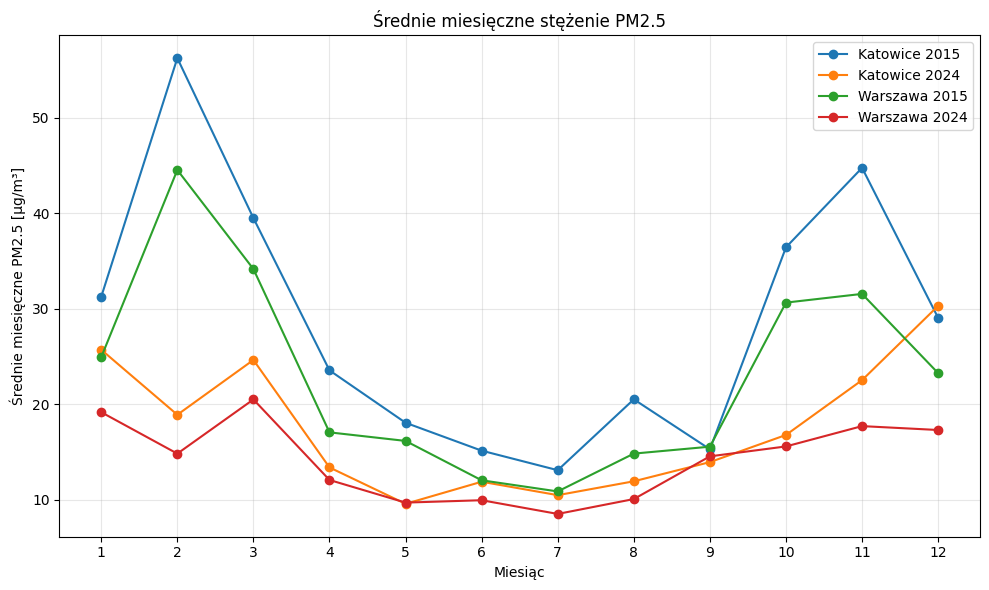

In [83]:
#wyciągam warszawę i katowice (już w vis.py)
plot_monthly_pm25(
    monthly_city
)

Wykres przedstawia średnie miesięczne stężenia pyłu PM2.5
[
𝜇
𝑔
/
𝑚
3
]
[μg/m
3
] dla dwóch miast: Katowic i Warszawy, porównując dwa lata: 2015 oraz 2024. Oś pozioma odpowiada kolejnym miesiącom roku
(
1
–
12
)
(1–12), natomiast oś pionowa przedstawia średnie miesięczne stężenie PM2.5.

Dla obu miast i analizowanych lat widoczna jest wyraźna sezonowość stężeń PM2.5. Najwyższe wartości występują w miesiącach zimowych (styczeń–marzec oraz listopad–grudzień), natomiast najniższe w okresie letnim (czerwiec–sierpień). Zjawisko to wynika głównie z intensyfikacji emisji w sezonie grzewczym oraz gorszych warunków dyspersji zanieczyszczeń zimą.

Porównanie lat wskazuje na istotne obniżenie poziomu stężeń PM2.5 w 2024 roku w stosunku do 2015 roku, szczególnie w Katowicach. W 2015 roku Katowice charakteryzowały się bardzo wysokimi stężeniami zimą, przekraczającymi miejscami
50

𝜇
𝑔
/
𝑚
3
50μg/m
3
, podczas gdy w 2024 roku wartości te są wyraźnie niższe i nie przekraczają około
30

𝜇
𝑔
/
𝑚
3
30μg/m
3
. W Warszawie również obserwuje się spadek stężeń w 2024 roku, choć skala zmian jest mniejsza niż w przypadku Katowic.

### 3. Heatmapa miesięcznych średnich
Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [84]:
lata_do_heatmapy = [2015, 2018, 2021, 2024]
df_sel = df_all[df_all["Data"].dt.year.isin(lata_do_heatmapy)].copy()
df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

df_long["PM25"] = pd.to_numeric(df_long["PM25"], errors="coerce")

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
df_long["Miasto"].isna().sum()
monthly_city = (
    df_long
    .groupby(
        [
            df_long["Data"].dt.year.rename("Rok"),
            df_long["Data"].dt.month.rename("Miesiac"),
            "Miasto"
        ]
    )["PM25"]
    .mean()
    .reset_index()
)

monthly_city.head()



,Rok,Miesiac,Miasto,PM25
0,2015,1,Białystok,22.458108
1,2015,1,Bydgoszcz,23.300085
2,2015,1,Gdańsk,15.260864
3,2015,1,Jelenia Góra,24.520156
4,2015,1,Kalisz,32.039201


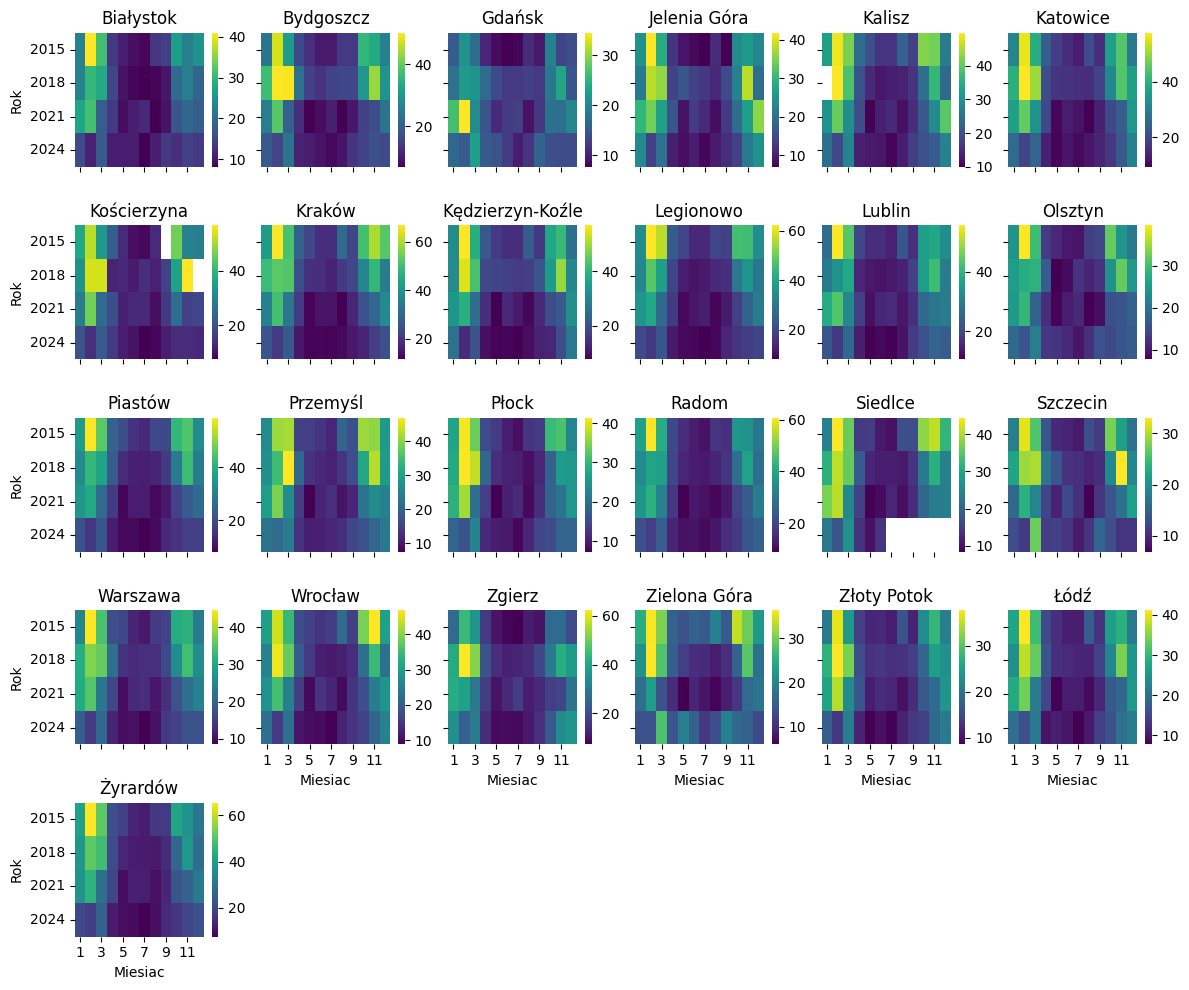

In [85]:
plot_pm25_heatmaps(monthly_city)

Interpretacja wyników:

W większości miejscowości można zaobserwować stosunkowo podobne trendy (analogiczne do tych zaobserwowanych w zad. 2).
W miesiącach zimowych występują najwyższe stężenia PM2.5 - prawdopodobnie powiązane z ogrzewaniem domów.
W późniejszych latach są stabilnie niższe stężenia PM2.5 - potencjalnie związane z modernizacją systemów grzewczych i zaostrzeniem norm emisji. Pojawiające się w niektórych panelach białe pola odpowiadają brakom danych pomiarowych dla danej kombinacji roku i miesiąca, powstały przez niekompletność danych źródłowych

### 4. Dni z przekroczeniem normy (WHO)

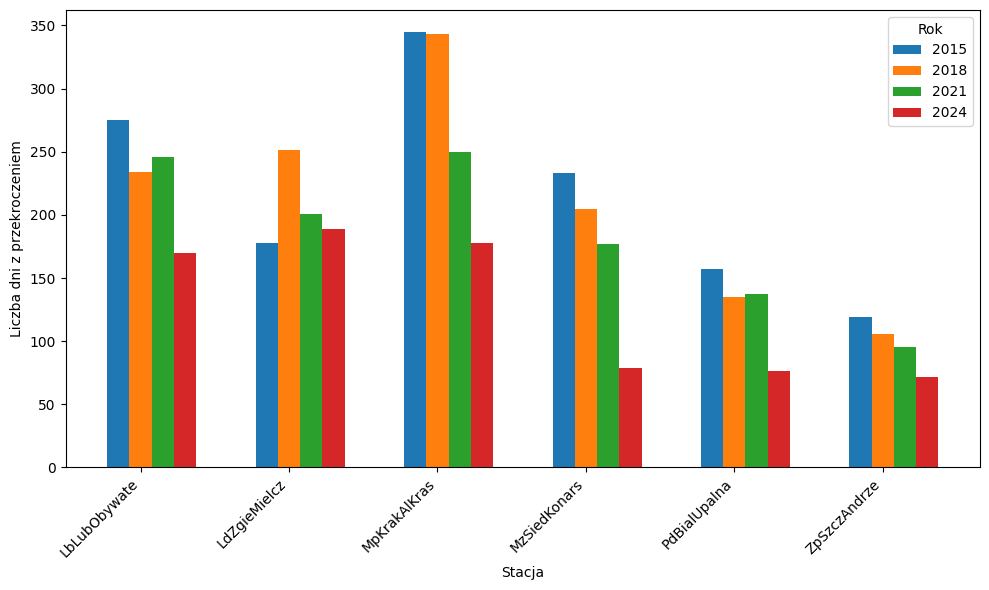

Rok,2015,2018,2021,2024
Kod_stacji,,,,
LbLubObywate,275,234,246,170
LdZgieMielcz,178,251,201,189
MpKrakAlKras,345,343,250,178
MzSiedKonars,233,205,177,79
PdBialUpalna,157,135,137,76
ZpSzczAndrze,119,106,95,72


In [ ]:
df_sel = df_all[df_all["Data"].dt.year.isin(lata)].copy()

df = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')

df_daily=daily_station_mean(df)
counts=exceedance_days_per_year(df_daily)

top3 = counts[counts['Rok']==2024].nlargest(3,'przekracza')
bottom3 = counts[counts['Rok']==2024].nsmallest(3,'przekracza')

selected = pd.concat([top3,bottom3])['Kod_stacji'].unique()

plot_df = counts[counts['Kod_stacji'].isin(selected)]

pivot = plot_df.pivot(index='Kod_stacji', columns='Rok', values='przekracza')

fig, ax = plt.subplots(figsize=(10,6))
years = sorted(pivot.columns)
x = range(len(pivot.index))
bar_width=0.15

for i, year in enumerate(years):
    ax.bar([p + i*bar_width for p in x], pivot[year], width=bar_width, label=str(year))

ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.set_ylabel("Liczba dni z przekroczeniem")
ax.set_xlabel("Stacja")
ax.legend(title="Rok")

plt.tight_layout()
plt.show()

pivot


### Zadanie 5
Przygotuj kod, który wygeneruje wykres pokazujący liczbę dni z przekroczeniem normy stężenia PM2.5 (średnie dzienne stężenie) grupując dane po województwach. Dodaj opis i wyniki do notatnika jako zadanie 5. 

In [87]:
# tworzenie df z potrzebnymi danymi 

lata_do_wykresu = [2015, 2018, 2021, 2024]

df_sel = df_all[df_all["Data"].dt.year.isin(lata_do_wykresu)].copy()

df_long = df_sel.melt(
    id_vars="Data",
    var_name="Kod_stacji",
    value_name="PM25"
)

df_long["Miasto"] = df_long["Kod_stacji"].map(kod2miasto)
df_long["Miasto"].isna().sum()

df = df_long.copy()

In [88]:

df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year

# Widzę, że dla 2018 sa przecinki zamiast kropek
df[df['Rok']==2018]['PM25']



8759       43.0102
8760       5.38425
8761       4.52882
8762       8.68036
8763           7.2
            ...   
1034341    17.2711
1034342    18.7469
1034343    23.7844
1034344    20.0236
1034345    32.0525
Name: PM25, Length: 262800, dtype: object

In [89]:
mask_2018 = df['Rok'] == 2018

# Zamieniam przecinki na kropki w kolumnie 'PM25' dla roku 2018

df.loc[mask_2018, 'PM25'] = (
    df.loc[mask_2018, 'PM25']
      .astype(str)
      .str.replace(',', '.', regex=False)
)

In [90]:
df['PM25'] = pd.to_numeric(df['PM25'], errors='coerce')
df['PM25'].dtype  # float64

df_daily=daily_station_mean(df) 

# Wczytanie metadanych
meta = pd.read_excel('Metadane oraz kody stacji i stanowisk pomiarowych.xlsx')

# Znajdowanie nazw kolumn z Kodem stacji i Województwem
col_stacja = next((col for col in meta.columns if 'Kod stacji' in str(col)), 'Kod stacji')
col_woj = next((col for col in meta.columns if 'Województwo' in str(col)), 'Województwo')

# Mapowanie
mapping = dict(zip(meta[col_stacja], meta[col_woj]))

counts=exceedance_days_per_year(df_daily)
counts['Województwo']=counts["Kod_stacji"].map(mapping)
calosc=(
    counts.groupby(['Rok','Województwo'],as_index=False)['przekracza']
    .mean()
)

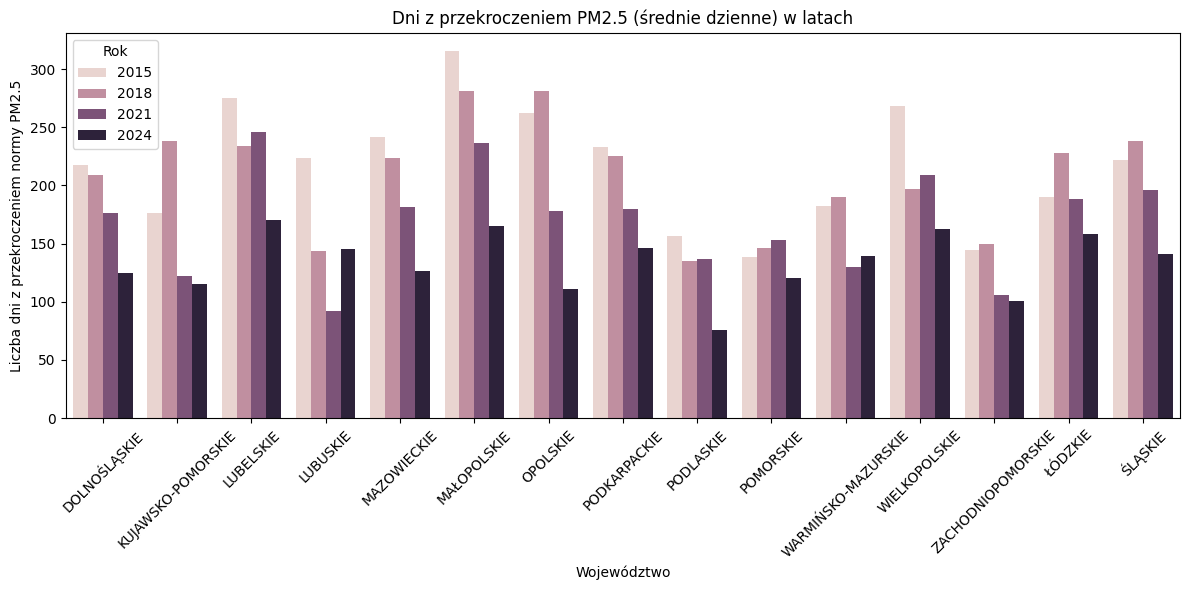

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    data=calosc,
    x='Województwo',
    y='przekracza',  # liczba dni z przekroczeniem
    hue='Rok'        # różne lata 
)

plt.xticks(rotation=45)
plt.ylabel("Liczba dni z przekroczeniem normy PM2.5")
plt.xlabel("Województwo")
plt.title("Dni z przekroczeniem PM2.5 (średnie dzienne) w latach")
plt.legend(title='Rok')
plt.tight_layout()
plt.show()

### Interpretacja

Rok 2018 był rokiem z największą ilością przekroczeń w wielu województwach, można to zdarzenie skorelować z długotrwałym niżem, który unosił się w tym roku nad Polską z wyjątkiem wschodu kraju - stąd niskie słupki dla Podlasia i Lubelszczyzny. Po korekcji widać że województwa mające większą średnią ilość przekroczeń to małopolskie, wielkopolskie i lubelskie. Widać tendencję spadkową w każdym województwie z wyjątkiem roku 2018, ale rok 2015 zawsze ma większą ilość wykroczeń od 2024. Można wywnioskować że modernizacja instalacji cieplnych jak i częściowe przejście na czystsze formy pozyskiwania energii mają swoje efekty. Województwa w których jest większa ilość miast albo występuje wyjątkowo duże miasto - np Kraków mają więcej przekroczeń niż inne. Najlepiej wypada województwo podlaskie, które w 2018 roku nie odnotowało żadnych przekroczeń.
